In [1]:
# Importing the liberaries 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import shap

In [2]:
df = pd.read_csv("online_shoppers_intention.csv")

In [3]:
# Changing the boolean datatypes into integer datatypes
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [4]:
# Changing the other categorical variables into integer datatypes using ordinal encoding
# This transforms categorical value to numerical value in ordered sets through a dictionary

Month_dict = {'Feb' : 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df['Month'] = df.Month.map(Month_dict)

VisitorType_dict = {'Other': 0, 'New_Visitor' : 1, 'Returning_Visitor': 2}

df['VisitorType'] = df.VisitorType.map(VisitorType_dict)

In [5]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,1,0


In [6]:
X = df.drop('Revenue', 1)
y = df['Revenue']

In [7]:
# use the BaggingClassifier scikit-sklearn to create a bagged decision tree model
cart = DecisionTreeClassifier()
num_trees = 100
bagging_model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=7)


In [8]:
# evaluate bagging algorithm for classification
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(bagging_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [9]:
print(np.mean(n_scores))

0.901513922681806


In [10]:
y_pred_bagging = cross_val_predict(bagging_model, X, y, cv=5)

In [11]:
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(y, y_pred_bagging)
print(classification_report(y, y_pred_bagging))
print("Cohen's Kappa:", cohen_kappa_score(y, y_pred_bagging))
print("F1 score: ", f1_score(y, y_pred_bagging))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10422
           1       0.70      0.55      0.62      1908

    accuracy                           0.89     12330
   macro avg       0.81      0.75      0.78     12330
weighted avg       0.89      0.89      0.89     12330

Cohen's Kappa: 0.5553020481727706
F1 score:  0.6162383177570093


Bagged decision trees outperform logistic regression without the use of oversampling. The Bagged Decision Trees tend to predict class 0 rather than class 1, because of the imbalanced data.

In [12]:
# Use oversampling using SMOTE for the imbalanced dataset
columns = X.columns
os = SMOTE(random_state = 0)
os_data_X, os_data_y = os.fit_resample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Revenue'])

In [13]:
X_os=os_data_X
y_os=os_data_y['Revenue']

In [14]:
n_scores_os = cross_val_score(bagging_model, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [15]:
print(np.mean(n_scores_os))

0.9301798670287825


In [16]:
y_pred_bagging_os = cross_val_predict(bagging_model, X_os, y_os, cv=5)

In [17]:
matrix = confusion_matrix(y_os, y_pred_bagging_os)
print(classification_report(y_os, y_pred_bagging_os))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_bagging_os))
print("F1 score: ", f1_score(y_os, y_pred_bagging_os))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     10422
           1       0.89      0.93      0.91     10422

    accuracy                           0.91     20844
   macro avg       0.91      0.91      0.91     20844
weighted avg       0.91      0.91      0.91     20844

Cohen's Kappa: 0.8144310113222031
F1 score:  0.9094145199063232


Oversampling improved the results significantly, and bagged decision trees outperformed logisitic regression.

In [20]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X_os):
    # split data
    X_train, X_test = X_os.iloc[train_ix, :], X_os.iloc[test_ix, :]
    y_train, y_test = y_os[train_ix], y_os[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    # define the model
    model = BaggingClassifier(base_estimator=cart, random_state=7)
    # define search space
    space = dict()
    space['n_estimators'] = [10, 50, 100, 500, 1000]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))


>acc=0.932, est=0.928, cfg={'n_estimators': 500}
>acc=0.931, est=0.929, cfg={'n_estimators': 500}
>acc=0.929, est=0.928, cfg={'n_estimators': 1000}
>acc=0.933, est=0.927, cfg={'n_estimators': 1000}
>acc=0.927, est=0.928, cfg={'n_estimators': 1000}
Accuracy: 0.930 (0.002)


In [41]:
bagging_model = BaggingClassifier(base_estimator=cart, n_estimators=500, random_state=7)
n_scores = cross_val_score(bagging_model, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(np.mean(n_scores))

0.9307715280210836


In [42]:
y_pred_bagging_os = cross_val_predict(bagging_model, X_os, y_os, cv=5)

In [43]:
matrix = confusion_matrix(y_os, y_pred_bagging_os)
print(classification_report(y_os, y_pred_bagging_os))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_bagging_os))
print("F1 score: ", f1_score(y_os, y_pred_bagging_os))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     10422
           1       0.89      0.93      0.91     10422

    accuracy                           0.91     20844
   macro avg       0.91      0.91      0.91     20844
weighted avg       0.91      0.91      0.91     20844

Cohen's Kappa: 0.814622913068509
F1 score:  0.9096351730589336


For fold 1:
Accuracy: 0.884304932735426
f-score: 0.873961895456766
Results on the test set:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2230
           1       0.96      0.80      0.87      2230

    accuracy                           0.88      4460
   macro avg       0.89      0.88      0.88      4460
weighted avg       0.89      0.88      0.88      4460



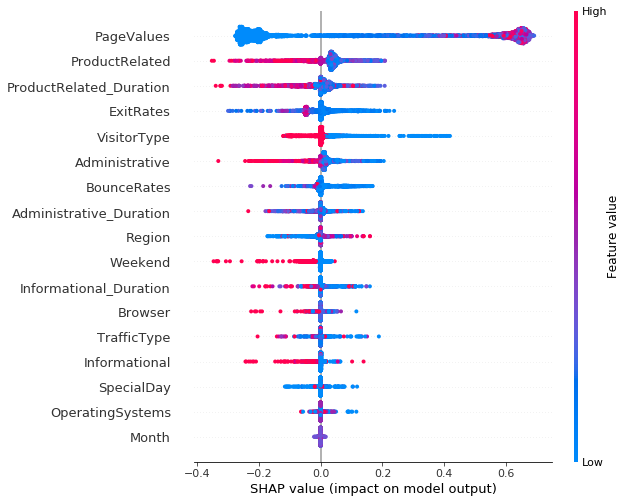

For fold 2:
Accuracy: 0.9462341197822142
f-score: 0.9474617601418754
Results on the test set:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2204
           1       0.93      0.97      0.95      2204

    accuracy                           0.95      4408
   macro avg       0.95      0.95      0.95      4408
weighted avg       0.95      0.95      0.95      4408



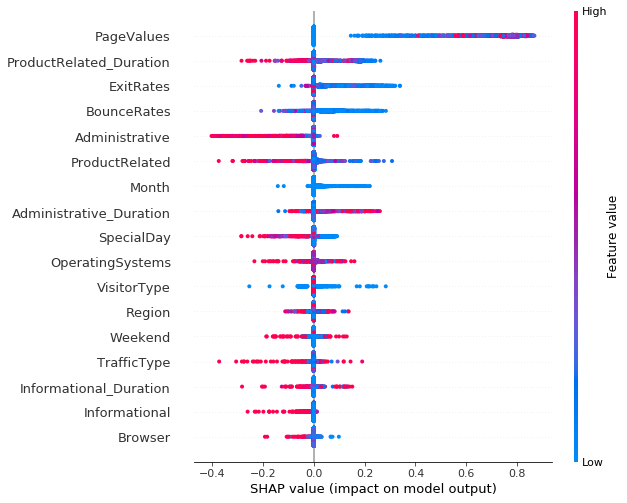

For fold 3:
Accuracy: 0.8805245264691598
f-score: 0.8834123222748814
Results on the test set:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2059
           1       0.86      0.91      0.88      2059

    accuracy                           0.88      4118
   macro avg       0.88      0.88      0.88      4118
weighted avg       0.88      0.88      0.88      4118



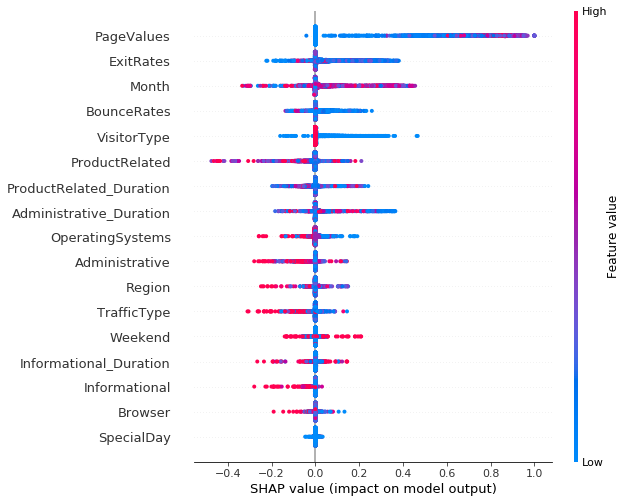

For fold 4:
Accuracy: 0.8671435871231477
f-score: 0.8621420996818665
Results on the test set:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1957
           1       0.90      0.83      0.86      1957

    accuracy                           0.87      3914
   macro avg       0.87      0.87      0.87      3914
weighted avg       0.87      0.87      0.87      3914



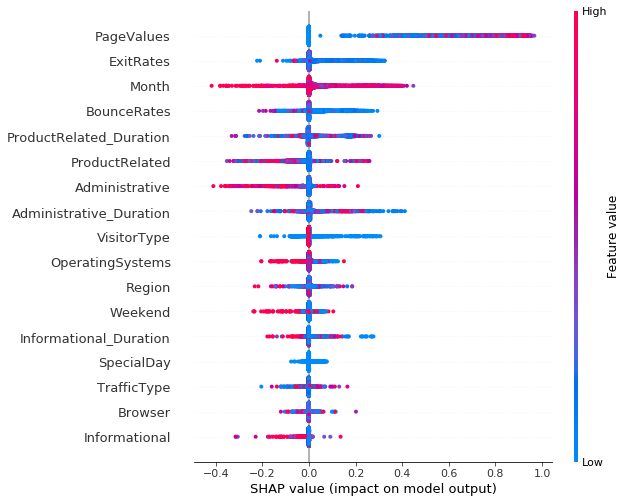

For fold 5:
Accuracy: 0.8630831643002028
f-score: 0.8542903399892068
Results on the test set:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1972
           1       0.91      0.80      0.85      1972

    accuracy                           0.86      3944
   macro avg       0.87      0.86      0.86      3944
weighted avg       0.87      0.86      0.86      3944



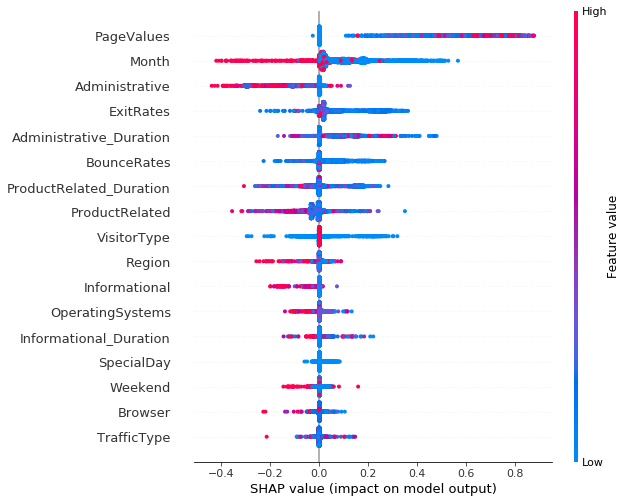

In [45]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    X_train_oversampled, y_train_oversampled = os.fit_resample(X_train, y_train)
    X_test_oversampled, y_test_oversampled = os.fit_resample(X_test, y_test)
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500, random_state=7)
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred_oversampled = model.predict(X_test_oversampled)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test_oversampled, y_test_oversampled)}')
    print(f'f-score: {f1_score(y_test_oversampled, y_pred_oversampled)}')
    print('Results on the test set:')
    print(classification_report(y_test_oversampled, y_pred_oversampled))
    explainer = shap.KernelExplainer(model.predict, X_train_oversampled[:10])
    shap_values = explainer.shap_values(X_test_oversampled)
    shap.summary_plot(shap_values, X_test_oversampled)
    #print(X_test_oversampled.mean())
    #print(np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0))#

The accuracy score for the second fold is the highest, indicating that PageValues, ProductRelated_Duration, and ExitRates are the most important features.

In [46]:
# Feature importance scores
shap_sum = (shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df 

,column_name,shap_importance
8,PageValues,0.263204
10,Month,0.0886505
7,ExitRates,0.0705302
1,Administrative_Duration,0.0563925
6,BounceRates,0.0409125
5,ProductRelated_Duration,0.0161482
3,Informational_Duration,0.00324417
9,SpecialDay,0.00314116
11,OperatingSystems,0.00220609
13,Region,0.0016892


In [47]:
# Feature importance scores
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.263218
10,Month,0.101754
0,Administrative,0.078009
7,ExitRates,0.0737877
1,Administrative_Duration,0.0577427
6,BounceRates,0.0462009
5,ProductRelated_Duration,0.0417248
4,ProductRelated,0.0323266
15,VisitorType,0.0128882
13,Region,0.006724


Random Forest

In [24]:
X = df.drop('Revenue', 1)
y = df['Revenue']

In [25]:
# evaluate RandomForest algorithm for classification
max_features = 3
rf_model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)

In [26]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

n_scores_rf = cross_val_score(rf_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')


In [27]:
print(np.mean(n_scores_rf))

0.9020005406866721


In [28]:
y_pred_rf = cross_val_predict(rf_model, X, y, cv=5)

In [29]:
matrix = confusion_matrix(y, y_pred_rf)
print(classification_report(y, y_pred_rf))
print("Cohen's Kappa:", cohen_kappa_score(y, y_pred_rf))
print("F1 score: ", f1_score(y, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10422
           1       0.72      0.53      0.61      1908

    accuracy                           0.89     12330
   macro avg       0.82      0.74      0.77     12330
weighted avg       0.89      0.89      0.89     12330

Cohen's Kappa: 0.5478033155449265
F1 score:  0.6069591527987898


The results of the bagged decision tree and the random forest are almost the same. This is because both models use multiple decision trees but in a different way. Random Forest also outperforms logistic regression. 

In [30]:
# Use oversampling using SMOTE for the imbalanced dataset
columns = X.columns
os = SMOTE(random_state = 0)
os_data_X, os_data_y = os.fit_resample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Revenue'])

In [31]:
X_os=os_data_X
y_os=os_data_y['Revenue']

In [32]:
n_scores_os_rf = cross_val_score(rf_model, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [33]:
print(np.mean(n_scores_os_rf))

0.9317311019840405


In [34]:
y_pred_rf_os = cross_val_predict(rf_model, X_os, y_os, cv=5)

In [35]:
matrix = confusion_matrix(y_os, y_pred_rf_os)
print(classification_report(y_os, y_pred_rf_os))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_rf_os))
print("F1 score: ", f1_score(y_os, y_pred_rf_os))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     10422
           1       0.89      0.94      0.91     10422

    accuracy                           0.91     20844
   macro avg       0.91      0.91      0.91     20844
weighted avg       0.91      0.91      0.91     20844

Cohen's Kappa: 0.8225868355402034
F1 score:  0.9134565878773696


When oversampling is used, the results are significanlty better. Random Forest outperforms Logistic Regression and outperforms bagged decision trees by a small margin.

In [37]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X_os):
    # split data
    X_train, X_test = X_os.iloc[train_ix, :], X_os.iloc[test_ix, :]
    y_train, y_test = y_os[train_ix], y_os[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state = 7)
    # define search space
    space = dict()
    space['n_estimators'] = [100, 300, 500, 800, 1000]
    space['max_features'] = ['sqrt', 'log2']
    #space['max_depth'] = [None, 1, 3, 5, 8, 15, 25, 30]
    #space['min_samples_split'] = [5, 10]
    #space['min_samples_leaf'] = [1, 2, 5, 10]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))


>acc=0.936, est=0.929, cfg={'max_features': 'sqrt', 'n_estimators': 100}
>acc=0.930, est=0.930, cfg={'max_features': 'sqrt', 'n_estimators': 500}
>acc=0.929, est=0.930, cfg={'max_features': 'sqrt', 'n_estimators': 300}
>acc=0.935, est=0.928, cfg={'max_features': 'sqrt', 'n_estimators': 1000}
>acc=0.927, est=0.931, cfg={'max_features': 'sqrt', 'n_estimators': 800}
Accuracy: 0.932 (0.004)


In [38]:
rf_model_cv = RandomForestClassifier(n_estimators=100, max_features= 'sqrt')
n_scores_os_rf = cross_val_score(rf_model_cv, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(np.mean(n_scores_os_rf))

0.9319869625409005


In [39]:
y_pred_rf_os_cv = cross_val_predict(rf_model_cv, X_os, y_os, cv=5)

In [40]:
matrix = confusion_matrix(y_os, y_pred_rf_os_cv)
print(classification_report(y_os, y_pred_rf_os_cv))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_rf_os_cv))
print("F1 score: ", f1_score(y_os, y_pred_rf_os_cv))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     10422
           1       0.89      0.94      0.91     10422

    accuracy                           0.91     20844
   macro avg       0.91      0.91      0.91     20844
weighted avg       0.91      0.91      0.91     20844

Cohen's Kappa: 0.823354442525427
F1 score:  0.9138632854536096


For fold 1:
Accuracy: 0.9089686098654709
f-score: 0.9040189125295509
Results on the test set:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2230
           1       0.96      0.86      0.90      2230

    accuracy                           0.91      4460
   macro avg       0.91      0.91      0.91      4460
weighted avg       0.91      0.91      0.91      4460



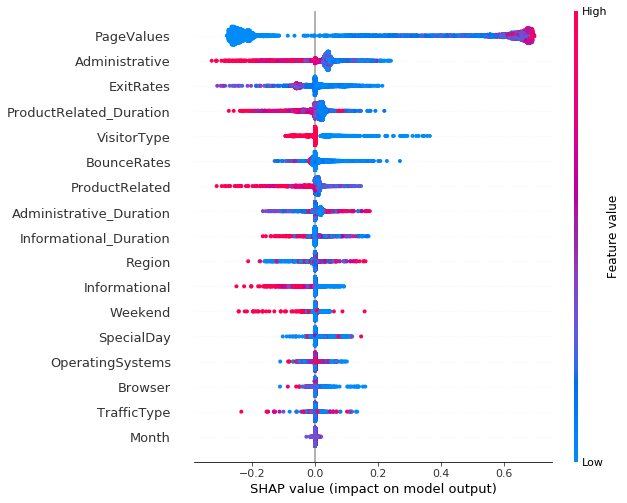

For fold 2:
Accuracy: 0.9489564428312159
f-score: 0.9507550886408405
Results on the test set:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2204
           1       0.92      0.99      0.95      2204

    accuracy                           0.95      4408
   macro avg       0.95      0.95      0.95      4408
weighted avg       0.95      0.95      0.95      4408



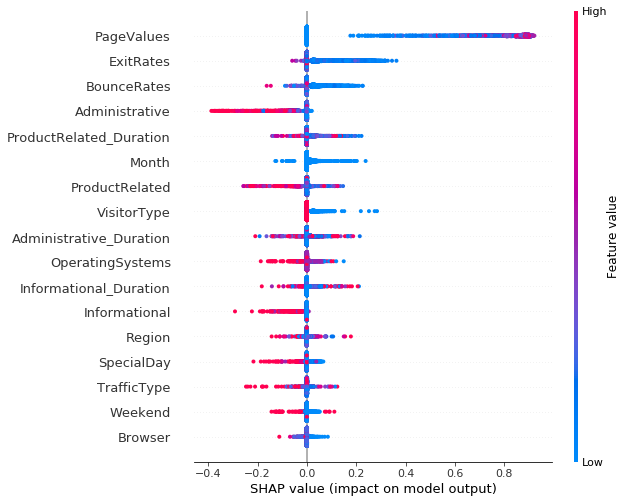

For fold 3:
Accuracy: 0.8882952889752307
f-score: 0.8906324298621017
Results on the test set:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2059
           1       0.87      0.91      0.89      2059

    accuracy                           0.89      4118
   macro avg       0.89      0.89      0.89      4118
weighted avg       0.89      0.89      0.89      4118



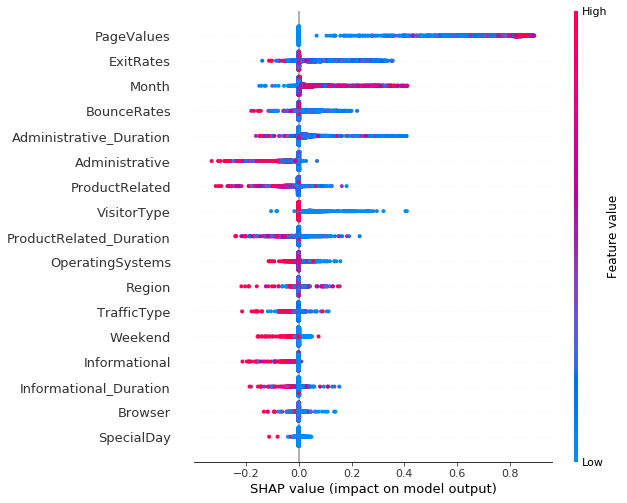

For fold 4:
Accuracy: 0.8742973939703628
f-score: 0.8687299893276414
Results on the test set:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1957
           1       0.91      0.83      0.87      1957

    accuracy                           0.87      3914
   macro avg       0.88      0.87      0.87      3914
weighted avg       0.88      0.87      0.87      3914



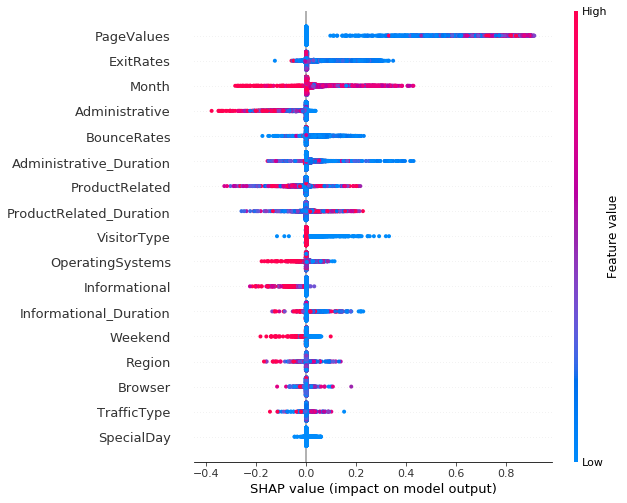

For fold 5:
Accuracy: 0.8666328600405679
f-score: 0.8578378378378378
Results on the test set:
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1972
           1       0.92      0.80      0.86      1972

    accuracy                           0.87      3944
   macro avg       0.87      0.87      0.87      3944
weighted avg       0.87      0.87      0.87      3944



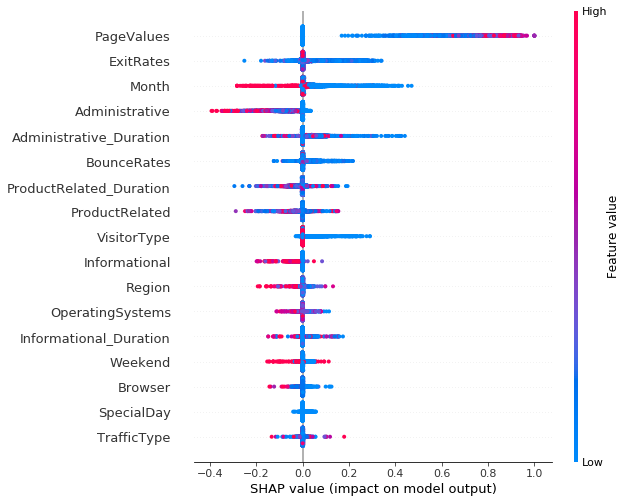

In [53]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    X_train_oversampled, y_train_oversampled = os.fit_resample(X_train, y_train)
    X_test_oversampled, y_test_oversampled = os.fit_resample(X_test, y_test)
    model = RandomForestClassifier(n_estimators=100, max_features= 'sqrt')
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred_oversampled = model.predict(X_test_oversampled)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test_oversampled, y_test_oversampled)}')
    print(f'f-score: {f1_score(y_test_oversampled, y_pred_oversampled)}')
    print('Results on the test set:')
    print(classification_report(y_test_oversampled, y_pred_oversampled))
    #explainer = shap.TreeExplainer(model)
    explainer = shap.KernelExplainer(model.predict, X_train_oversampled[:10])
    shap_values_rf = explainer.shap_values(X_test_oversampled)
    shap.summary_plot(shap_values_rf, X_test_oversampled)
    #print(X_test_oversampled.mean())

The accuracy score for the second fold is the highest, indicating that PageValues, ExitRates, and BounceRates are the most important features.

In [54]:
# Feature importance scores
shap_sum = (shap_values_rf).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df 

,column_name,shap_importance
8,PageValues,0.334132
7,ExitRates,0.0557488
10,Month,0.0475085
1,Administrative_Duration,0.0319225
6,BounceRates,0.0281591
15,VisitorType,0.00984991
3,Informational_Duration,0.00333507
11,OperatingSystems,0.00251748
9,SpecialDay,0.00239817
13,Region,0.00212844


In [55]:
# Feature importance scores
shap_sum = np.abs(shap_values_rf).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df 

,column_name,shap_importance
8,PageValues,0.334132
7,ExitRates,0.0624164
10,Month,0.0554295
0,Administrative,0.0520791
1,Administrative_Duration,0.0348207
6,BounceRates,0.0308263
5,ProductRelated_Duration,0.0194992
4,ProductRelated,0.0162024
15,VisitorType,0.0100977
2,Informational,0.00641277
